## Get Image points from videos

In [ ]:
%load_ext autoreload
%autoreload 2
from xmas_lights.core import read_video, select_frames, filter_frames, \
    digits_from_frame, xy_from_image, init_camera_matrix
from pathlib import Path 
import matplotlib.pyplot as plt
import numpy as np

num_hues = 3
num_bulbs = 50*8
num_flashes = 6
data_folder = Path("../data/Xmas Tree 2025")

caps, pts_xy = [], []
for i, path in enumerate(Path("../data/Xmas Tree 2025").glob("*.mp4")):
    frames, bright, _ = select_frames(read_video(path))
    frames_filt, fg = filter_frames(frames, num_flashes)
    frames_digit = [digits_from_frame(fr, fg, num_hues) for fr in frames_filt]
    im_id = np.sum([(fr.astype(float)*(num_hues**i)) * fg
                    for i, fr in enumerate(frames_digit)], axis=0).astype(int)
    im_id[im_id >= num_bulbs] = 0
    xys, ids, areas = xy_from_image(im_id, fg)
    caps.append({"frames":frames_filt, "bright": bright, "img_id":im_id, 
                 "xys": xys.copy(), "ids": ids.copy(), "file":path.name})
    pts_xy.append(np.ones((num_bulbs, 2)) * np.nan)
    pts_xy[-1][ids] = xys
    print(f"Video {i} found {len(np.unique(im_id))} bulbs")

num_views = len(caps)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Video 0 found 336 bulbs
Video 1 found 324 bulbs
Video 2 found 309 bulbs
Video 3 found 321 bulbs
Video 4 found 312 bulbs
Video 5 found 292 bulbs
Video 6 found 314 bulbs
Video 7 found 311 bulbs


## Initial estimate of 3D bulb positions and camera poses

In [ ]:
from xmas_lights.core import init_camera_pose, solve_pose_graph, init_world_positions, filt_sequence_inliers

cameraMatrix = init_camera_matrix(frames[0])
edges = init_camera_pose(pts_xy, cameraMatrix)
tfs = solve_pose_graph(edges)
pts = init_world_positions(pts_xy, tfs, cameraMatrix)

## Do bundle adjustment

In [ ]:
from xmas_lights.ba import torch_least_squares, mat_to_se_batch, ba_residuals_batch
import torch 

# [camera poses (except first), pts, f]
dtype = torch.float64
K = torch.as_tensor(cameraMatrix).to(dtype)
x1 = torch.as_tensor(np.r_[mat_to_se_batch(tfs[1:]).flatten(), 
                           pts.flatten(), 
                           cameraMatrix[0,0]])
observations = torch.from_numpy(np.stack(pts_xy)).to(dtype)

solution2 = torch_least_squares(
    lambda x: ba_residuals_batch(x, observations, K)[0],
    x1.to(dtype),
    max_iters=1_000,
    lr=1.0,
    loss='huber',
    huber_delta=1.0,
    verbose=True,
)

[00] cost = 33.625965
[10] cost = 11.680509  Δ=0.526758
[20] cost = 10.308609  Δ=0.052137
[30] cost = 10.079709  Δ=0.013779
[40] cost = 10.017208  Δ=0.007001
[50] cost = 9.988305  Δ=0.001961
[60] cost = 9.954789  Δ=0.003077
[70] cost = 9.941521  Δ=0.001031
[80] cost = 9.923098  Δ=0.000511
[90] cost = 9.918108  Δ=0.000124
[100] cost = 9.916978  Δ=0.000104
[110] cost = 9.915077  Δ=0.000070
[120] cost = 9.914694  Δ=0.000034
[130] cost = 9.914364  Δ=0.000036
[140] cost = 9.914004  Δ=0.000055
[150] cost = 9.913623  Δ=0.000013
[160] cost = 9.913278  Δ=0.000084
[170] cost = 9.913139  Δ=0.000003


## Refine, removing outliers

In [ ]:
_, obsh = ba_residuals_batch(solution2, observations, K)
err_img = obsh - observations 
res = err_img.flatten()
res = res[~res.isnan()]
dmax = res.abs().quantile(.9)

outlier = (err_img.abs() > dmax).any(-1)
obs_filt = observations.clone()
obs_filt[outlier] = torch.nan

solution2 = torch_least_squares(
    lambda x: ba_residuals_batch(x, obs_filt, K)[0],
    solution2,
    max_iters=1_000,
    lr=1.0,
    loss='huber',
    huber_delta=1.0,
    verbose=True,
)

[00] cost = 0.465930
[10] cost = 0.414467  Δ=0.000332
[20] cost = 0.413272  Δ=0.000014


## Sanity check: Compare against initial estimates

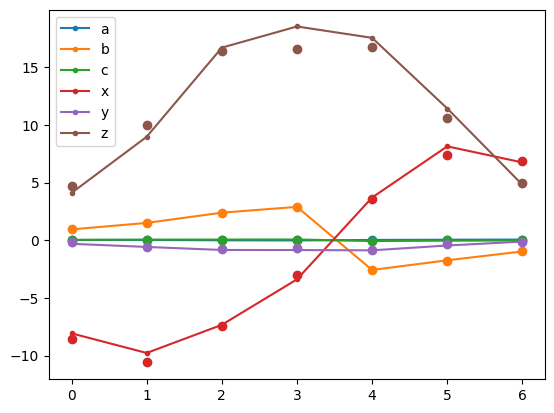

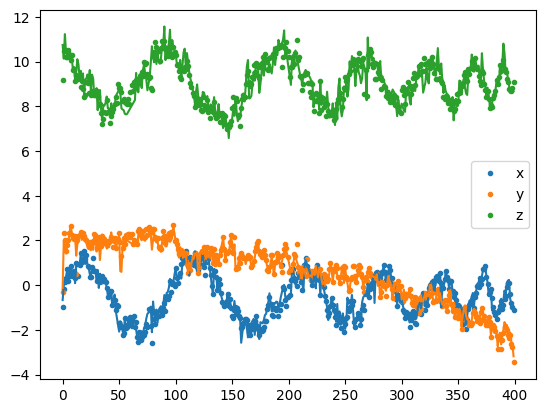

In [ ]:
se3_opt = solution2[:6*(num_views-1)].reshape(-1, 6)
se3 = mat_to_se_batch(tfs[1:])
pts_opt = solution2[6*(num_views-1):-1].reshape(-1, 3).numpy()

plt.plot(se3_opt, '.-')
plt.gca().set_prop_cycle(None)
plt.plot(se3, 'o')
plt.legend(['a', 'b', 'c', 'x', 'y', 'z']);

plt.figure()
plt.plot(pts_opt, '.');
plt.gca().set_prop_cycle(None)
plt.plot(pts, '-');
plt.legend(['x', 'y', 'z']);

## Normalize and rotate to real-life coordinates
z up, height = 1

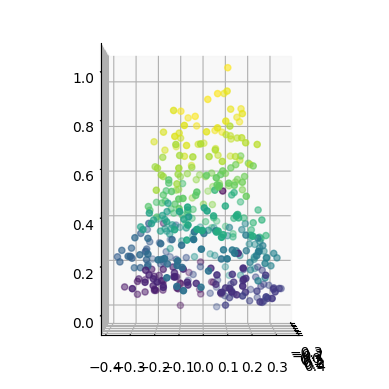

In [ ]:
pts_opt = solution2[6*(num_views-1):-1].reshape(-1, 3).numpy()
ids = np.arange(num_bulbs)
pts1, _ = filt_sequence_inliers(pts_opt)

cov_matrix = np.cov(pts1-np.mean(pts1, 0), rowvar=False)
eigenvalues, eigenvectors = np.linalg.eigh(cov_matrix)
pts2 = (pts1-np.mean(pts1, 0)) @ eigenvectors
if np.std(pts2[pts2[:,2] > 0,0]) > np.std(pts2[pts2[:,2] < 0,0]):
    pts2 = pts2 @ np.array([[1, 0, 0],
                            [0, -1, 0],
                            [0, 0, -1]])
pts2[:,2] -= np.quantile(pts2[:,2], 0.001)
pts2 /= np.diff(np.quantile(pts2[:,2], [0.001, 0.999]))

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d') # or use fig.add_subplot(projection='3d')
ax.scatter(pts2[:,0], pts2[:,1], pts2[:,2], c=ids, marker='o')
ax.view_init(elev=0., azim=0)
ax.set_aspect('equal')

## Print for arduino code

In [ ]:
pts3 = np.round(pts2 * 100).astype(int)
print("const int8_t cartesian[NUM_LEDS][3] = {")
for pt in pts3[:-1]:
    print(f"    {{{pt[0]}, {pt[1]}, {pt[2]}}},")
    # print(f"{{}}")
print(f"    {{{pts3[-1,0]}, {pts3[-1,1]}, {pts3[-1,2]}}}\n}};")

const int8_t cartesian[NUM_LEDS][3] = {
    {2, 8, 51},
    {-22, 8, 6},
    {-25, 5, 11},
    {-23, -1, 20},
    {-27, -6, 15},
    {-26, 4, 11},
    {-25, -1, 6},
    {-25, -10, 0},
    {-25, -2, 7},
    {-17, -10, 10},
    {-18, -10, 11},
    {-7, -11, 9},
    {-19, -17, 37},
    {-17, -18, 12},
    {-10, -11, 9},
    {-15, -18, 8},
    {-14, -29, 6},
    {-14, -21, 8},
    {-10, -25, 7},
    {-9, -34, 9},
    {-7, -28, 12},
    {-17, -25, 12},
    {-12, -19, 14},
    {-5, -22, 17},
    {-8, -12, 14},
    {1, -17, 17},
    {-6, -21, 14},
    {-8, -28, 13},
    {-1, -21, 8},
    {-2, -21, 9},
    {0, -13, 18},
    {1, -17, 11},
    {7, -21, 11},
    {9, -18, 13},
    {12, -24, 17},
    {19, -30, 10},
    {17, -25, 13},
    {12, -23, 15},
    {14, -21, 14},
    {8, -12, 16},
    {19, -12, 15},
    {19, -12, 15},
    {24, -19, 13},
    {20, -17, 11},
    {22, -7, 13},
    {19, -8, 18},
    {16, -6, 11},
    {15, 3, 18},
    {17, -3, 12},
    {6, 5, 11},
    {16, 14, 7},
    {17, 17, 14